# Project 2: Banker Helper


Mengyu Jackson

## Overview

Our stakeholder is a mortgage lender who would like more accurate appraisals to reduce risk for home loans. We analyzed the King County (CA) House Sales dataset using machine learning to develop a model for predicting the value of a house. The model accurately predicts the value of a house with information available to the bank at time of appraisal, and would be a good tool for making loan decisions. We recommend using this model along with existing appraisers to reduce risk and increase profit margins.

## Business Problem

Our stakeholder is a mortgage lender who wants to increase the accuracy of their appraisals in order to reduce the risk of default, especially loans which have the minimum possible down payment (20%) without Private Mortgage Insurance. These loans are worth 80% of the purchase price of the house. If a borrower defaults immediately, our stakeholder wants confidence they'll be able to re-sell the house and cover the entire loan. At the same time, they do not want artificially low appraisals, as those would drive clients to competing lenders. Specifically, we want to maximize the number of appraisals which are between 80% and 105% of the true value of the house in order to minimize risk while remaining attractive to borrowers.


## Data Understanding

This project uses the King County House Sales dataset, which can be found in `kc_house_data.csv` in the data folder in this repo. The description of the column names can be found in `column_names.md` in the same folder. As with most real world data sets, the column names are not perfectly described, so you'll have to do some research or use your best judgment if you have questions about what the data means.


- Where did the data come from, and how do they relate to the data analysis questions?
    The data come from house sales in King County, and they help us relate all of the features we are interested in (sqft, waterfront, renovated or not)
- What do the data represent? Who is in the sample and what variables are included?
    Only houses that have sold are in the sample, and variables include comparisons to nearby houses (_15 suffixed variables), metrics about the house that was sold and its lot (sqft), whether and when renovations were last done, and the original year it was built.
- What is the target variable?
    The target variable is the sale price of the house. A secondary target could be views; which could be used as a proxy for time-on-market.
- What are the properties of the variables you intend to use?
    Almost all of the variables we intend to use are numeric, except one binary variable (waterfront or not). Some of the variables are cyclic in nature (month), which we hope to capture in our feature selection.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import code.preprocessing as prep
import code.visualization as vis
from sklearn.model_selection import train_test_split
from sklearn import datasets, ensemble, linear_model, neural_network
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import RFECV

# NEW
from sklearn.inspection import plot_partial_dependence
from xgboost import XGBRegressor


## Data Preparation

Clean data:
* Id - remove.
* bedroom - replace outlier data. (33 bedrooms to 3)
* Waterfront - guess for Nan Value.
* Date - seperate year, month and day. Try sin/cos for month to cycle twelve months. remove date.
* sqft_living_dif - sqft_living -sqft_living15.
* sqft_lot_dif - sqft_lot - sqft_lot15.
* year_renovated - fill the Nan with the average of the renovated year, add new column 1 or 0 for renovated.
* sqft_basement - replace '?' to None.
* View -Removed


Since our business problem is making an appraisal, we only used data that would be available during an appraisal. This led us to remove the "views" variable. 

Most other changes helped specific models which we did not end up using (changing year_renovated to average, and introducing a new field helped when Scaling Data for input into NN models for example), but did not harm other models so kept the changes so we could evaluate all models on one data set.

For our business problem, explainability of the model was less of a concern than accuracy, so we kept correlated columns like sqft_above and sqft_living.

In [4]:
kc_house_data = pd.read_csv('./data/kc_house_data.csv')
copy_data = kc_house_data.copy()
clean_data, target_data = prep.clean_data(copy_data)

### First Model

After decide use sklean, first thing to try is `LinearRegression()`.

In [5]:
RANDOM_SEED = 5
X_train, X_test, y_train, y_test = train_test_split(clean_data, target_data, random_state = RANDOM_SEED)

In [6]:
prep.model(linear_model.LinearRegression(), X_train, X_test, y_train, y_test)

0.7178468857665168

## Modeling

Try different model:

* Ridge(random_state = RANDOM_SEED),
* BayesianRidge(),
* LinearRegression(),
* RandomForestRegressor(random_state = RANDOM_SEED),
* GradientBoostingRegressor(random_state = RANDOM_SEED),
* neural_network.MLPRegressor(solver="lbfgs", random_state = RANDOM_SEED)
* XGBRegressor() 

Use pipline with PCA, PolynomialFeatures or StandardScaler, use GridSearchCV to found the best hyperparameters:



Questions to consider:

We found explainability was good enough with partial_dependence plots, so we did not restrict our analysis to easily explainable models like linear regression. Explainability was less important because getting the right answer on average is the most important thing for making a profit as a mortgage lender.

Some variables had clear nonlinear effects (yr_built, latitude, longitude), which made it hard to get good performance from a linear model. We tried many different regressors built into scikitlearn with default parameters to decide which models were worth tuning. After we found that GradientBoostingRegressor was best, we decided to install and use xgboost (third party library for boosting decision trees) to see if that improved performance.

We decided xgboost was best, so we used GridSearchCV to find good hyperparameters without overfitting. We had to leave it running overnight several days in a row, but the results got us very close to our goal R^2 of .9.


In [7]:
xg_model= XGBRegressor(learning_rate=0.008, max_depth=6, gamma=0, n_estimators=4000, random_state= RANDOM_SEED)
prep.model(xg_model, X_train, X_test, y_train, y_test)

0.892431332061363

C:\Users\steve\anaconda3\lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:863: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots()
C:\Users\steve\anaconda3\lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:863: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots()
C:\Users\steve\anaconda3\lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:863: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`

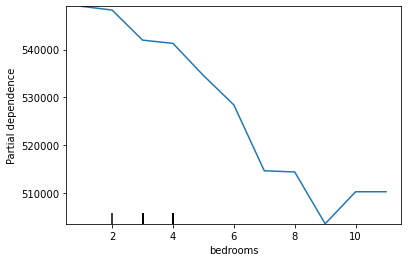

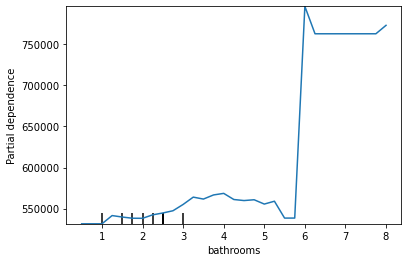

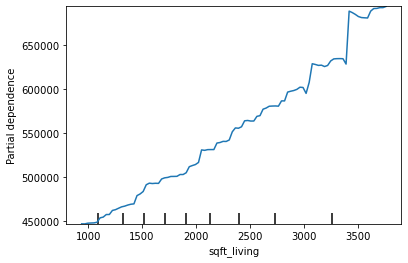

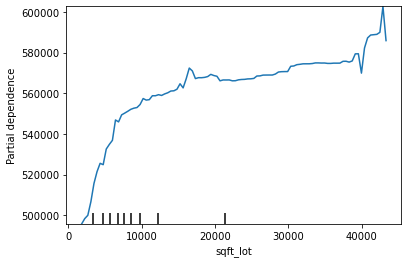

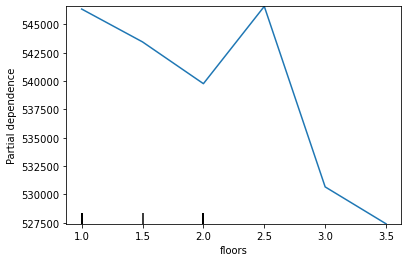

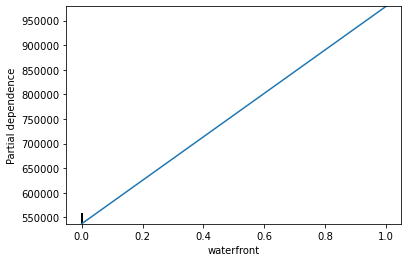

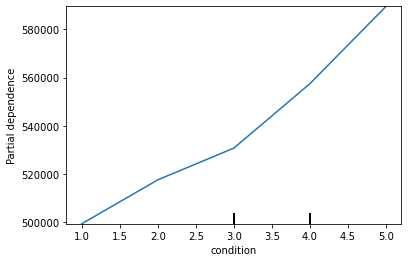

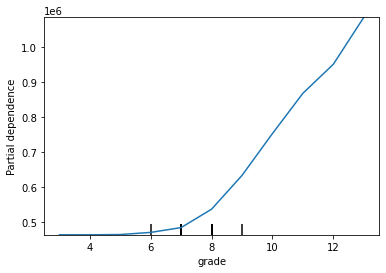

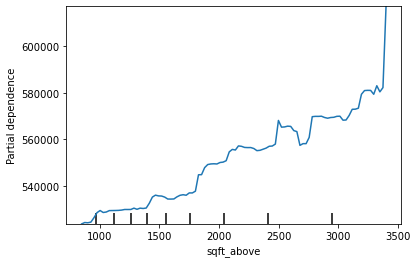

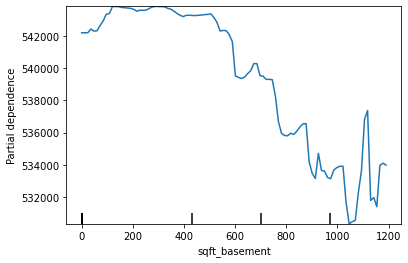

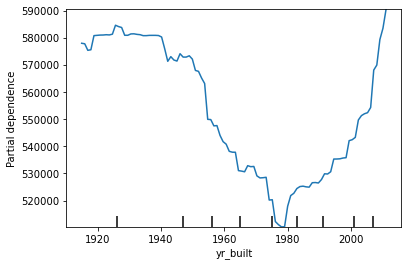

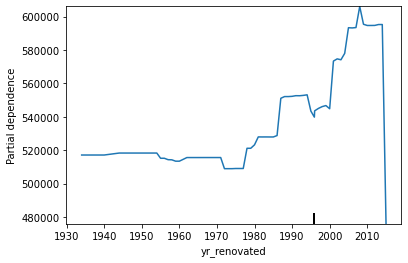

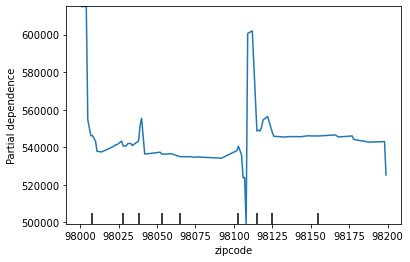

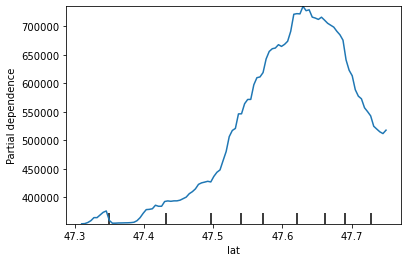

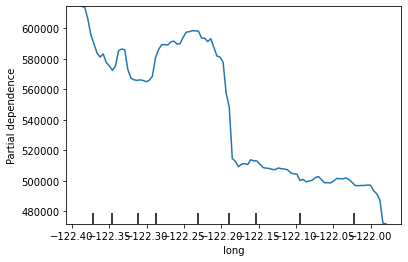

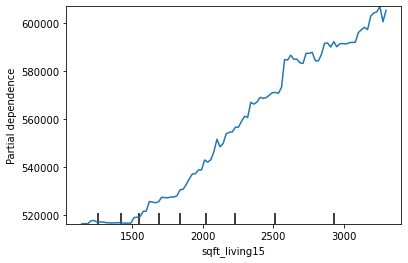

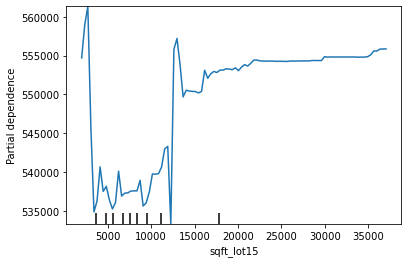

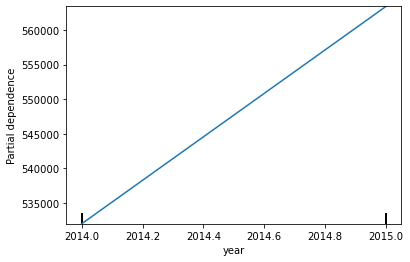

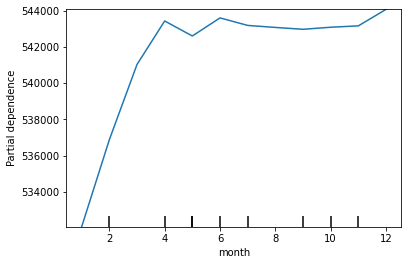

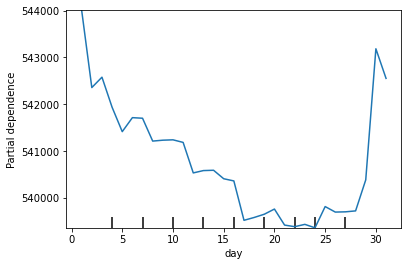

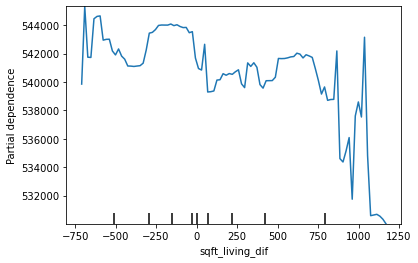

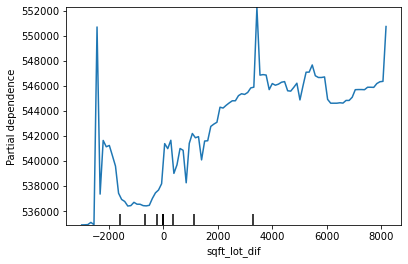

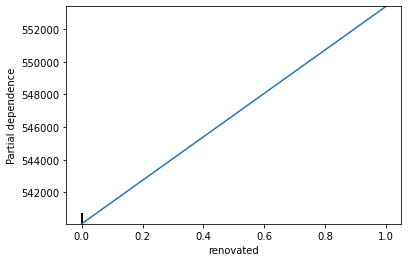

In [7]:
for column in X_train.columns:
    plot_partial_dependence(xg_model, clean_data,  [column])

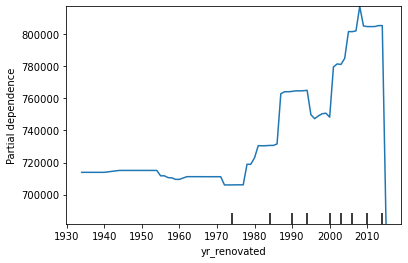

In [8]:
plot_partial_dependence(xg_model, clean_data[clean_data["renovated"]==1], ['yr_renovated'])

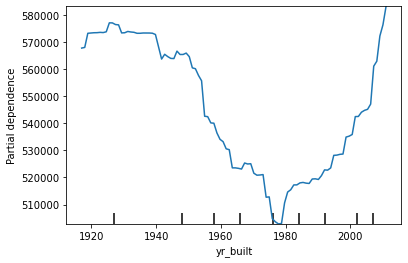

In [9]:
plot_partial_dependence(xg_model, clean_data[clean_data["renovated"]==0], ['yr_built'])

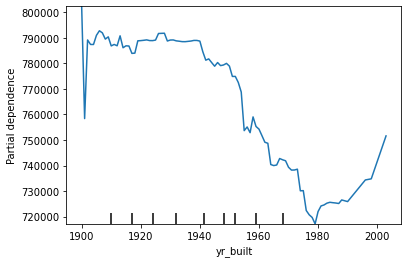

In [10]:
plot_partial_dependence(xg_model, clean_data[clean_data["renovated"]==1], ['yr_built'])

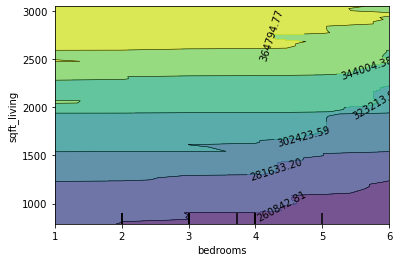

In [11]:
plot_partial_dependence(xg_model, clean_data[clean_data['zipcode'] == 98178], [('bedrooms', 'sqft_living')])

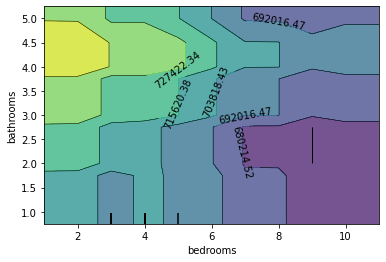

In [12]:
plot_partial_dependence(xg_model, 
                        clean_data[(clean_data['sqft_living'] < 3500) 
                                   & (clean_data['sqft_living'] > 2500)], 
                        [('bedrooms', 'bathrooms')])

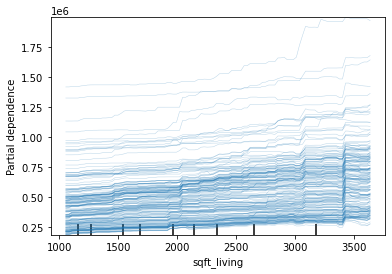

In [13]:
plot_partial_dependence(xg_model, clean_data[:200], ['sqft_living'], kind="individual")

## Evaluation

Evaluate how well your work solves the stated business problem.

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model?
- How well does your model/data fit any modeling assumptions?
- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?

Please note - you should be evaluating each model as you move through, and be sure to evaluate your models consistently.

In [14]:
waterfront = (clean_data["waterfront"] == 1)
not_waterfront = (clean_data["waterfront"] == 0)
pred_data = xg_model.predict(clean_data)

In [15]:
low_appraisals = pred_data * .8> target_data
good_appraisals = (pred_data * .8 <= target_data) & (pred_data * 1.05 >= target_data)
high_appraisals = pred_data *1.05 < target_data

# Houses where 80% of appraised value exceeded sale price
# Risk of losing money if borrowers default on these loans
print("Sale Price < 80% of Appraisal (Low Appraisal): ",len(clean_data[low_appraisals]))

# Houses where 100% of appraised value fell short of sale price
# Difficult to find borrowers for these loans
print("Sale Price between 80% and 105% of appraisal (Good Appraisal): ", len(clean_data[good_appraisals]))

# Borrowers will walk away
print("Sale price above 105% of appraisal (High Appraisal): ", len(clean_data[high_appraisals]))

Sale Price < 80% of Appraisal (Low Appraisal):  1128
Sale Price between 80% and 105% of appraisal (Good Appraisal):  14427
Sale price above 105% of appraisal (High Appraisal):  6042


In [16]:
total_low_loans = sum(pred_data[low_appraisals]*.8) 
total_good_loans = sum(pred_data[good_appraisals]*.8)
total_high_loans = sum(pred_data[high_appraisals]*.8)
# Do not include high, we assume the appraisal scared off borrowers
total_loans = total_low_loans +  total_good_loans

print("Total loans (Low Appraisals): ", total_low_loans)
print("Total loans (Good Appraisals): ", total_good_loans)
print("Total missed loans (High Appraisals): ", total_high_loans)
print("Total loans (total): ", total_loans)
print()
      
print("Average loan (Low Appraisals): ", total_low_loans/ len(pred_data[low_appraisals]))
print("Average loan (Good Appraisals): ", total_good_loans/ len(pred_data[good_appraisals]))
print("Average missed loan (High Appraisals): ", total_high_loans/ len(pred_data[high_appraisals]))
print()
      
      
# Houses where 80% of appraised value exceeded sale price
# Risk of losing money if borrowers default on these loans
immediate_default_losses = pred_data[low_appraisals]*.8 - target_data[low_appraisals]
print("Total losses from Low Appraisals (immediate default): ", sum(immediate_default_losses))
print("Losses from Low Appraisals (immediate default) as % of total loans : ", sum(immediate_default_losses) * 100/ total_loans)
print("Average loss from Low Appraisals (immediate default): ", sum(immediate_default_losses)/len(immediate_default_losses))
print()

Total loans (Low Appraisals):  400871010.2578125
Total loans (Good Appraisals):  6456764666.5078125
Total missed loans (High Appraisals):  2484016628.9492188
Total loans (total):  6857635676.765625

Average loan (Low Appraisals):  355382.10129238694
Average loan (Good Appraisals):  447547.28401662246
Average missed loan (High Appraisals):  411124.89721105905

Total losses from Low Appraisals (immediate default):  42868671.2578125
Losses from Low Appraisals (immediate default) as % of total loans :  0.6251231952005845
Average loss from Low Appraisals (immediate default):  38004.14118600399



In [17]:
loan_values = {'Low Loans': total_low_loans,
               'Good Loans': total_good_loans,
               'Missed Loans': total_high_loans}
number_appraisal = {'Low Appraisal': len(clean_data[low_appraisals]),
                    'Good Appraisal': len(clean_data[good_appraisals]),
                    'High Appraisal': len(clean_data[high_appraisals])
                   }
risk_loans = {'Total Loans': int(total_loans),
             'immediate default': int(sum(immediate_default_losses))}

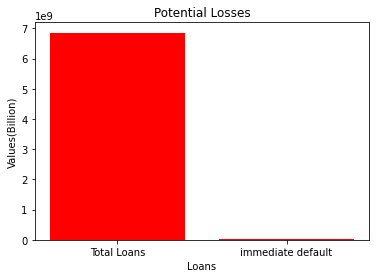

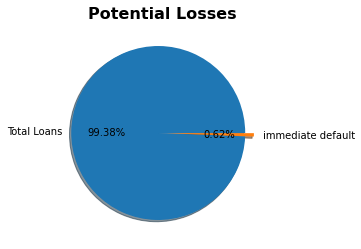

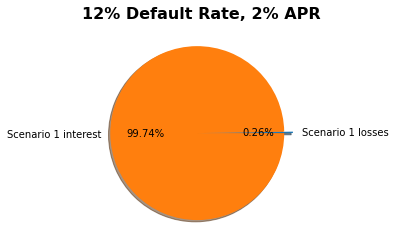

In [24]:
viz.bar_chart(risk_loans, "Loans", "Values(Billions)", "Potential Losses")

# Assume default rate of 50%, all defaults occur immediately.
scenario_1_default_rate  = .12
scenario_1_losses = immediate_default_losses * scenario_1_default_rate
# Assume 1% interest rate. 
# A 30 year fixed rate mortgage with a 2% APR would result in about 33% interest over the lifetime of the loan
scenario_1_interest = (total_loans * (1-scenario_1_default_rate)) * .33

scenario_1 = {
    "Scenario 1 losses": sum(scenario_1_losses),
    "Scenario 1 interest": scenario_1_interest,
}
vis.pie_chart(risk_loans, "Potential Losses")
vis.pie_chart(scenario_1, "12% Default Rate, 2% APR")

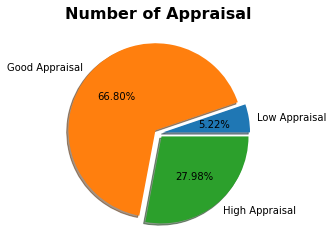

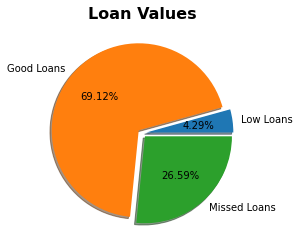

In [21]:
vis.pie_chart(number_appraisal, "Number of Appraisal")
vis.pie_chart(loan_values, "Loan Values")


In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(target_data, pred_data, squared=False), mean_absolute_error(target_data, pred_data)

(77028.68618202895, 44852.386111207576)

## Conclusions

The model is very good at predicting house prices in 2014-2015. Training on data outside this period will be necessary to help it understand larger trends in housing prices.
Using this model to appraise houses nearly guarantees interest made from loans will cover money lost to bad appraisals + default, even under very adverse assumptions (12% foreclosure rate, 2% APR).
We assumed the market remained stable during foreclosures; we did not analyze the case where a market crash depresses housing values simultaneously with default. That could increase losses significantly in a worst case scenario
This model could definitely generate a profit, but client should work with us to determine expected ROI using more realistic assumptions of default rate and APR to evaluate whether this model is more profitable than their existing process.